This notebook used to evaluate final model on 18 weeks of data, calculate performance metrics, find SHAP values for feature importance, and identify plays to use for the video portion of the project.

In [33]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, label_binarize
from sklearn import metrics 
import shap
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from scipy.stats import linregress
import matplotlib.patches as mpatches
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

## Import Data

In [2]:
data = pd.read_csv('Data/processed/data_for_model.csv')
pbp_data = pd.read_parquet('Data/play_by_play_2023.parquet')
pbp_data = pbp_data[['play_id', 'old_game_id', 'cp']]
pbp_data['play_id'] = pbp_data['play_id'].astype(int)
pbp_data['game_id'] = pbp_data['old_game_id'].astype(int)
supplementary_data = pd.read_csv('Data/supplementary_data.csv')
data = data.merge(pbp_data, on = ['game_id', 'play_id'], how = 'inner')
for col in data.select_dtypes(include=['int64']).columns:
    data[col] = data[col].astype(int)
for col in data.select_dtypes(include=['float64']).columns:
    data[col] = data[col].astype(float)
data['player_height'] = data['player_height'].apply(lambda x: int(x.split('-')[0])*12 + int(x.split('-')[1]))
data['seconds_left'] = data['game_clock'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
extra_seconds = {1: 60*15*3, 2: 60*15*2, 3: 60*15, 4: 0}
data['seconds_left'] = data['seconds_left'] + data['quarter'].map(extra_seconds)
data['player_position'] = data['player_position'].astype('category')
data['play_action'] = data['play_action'].astype('category')
data['dropback_type'] = data['dropback_type'].astype('category')
data['team_coverage_type'] = data['team_coverage_type'].astype('category')
data['route_of_targeted_receiver'] = data['route_of_targeted_receiver'].astype('category')
data['qb_hit'] = data['qb_hit'].astype('category')
data['down'] = data['down'].astype('category')
data['outcome'] = data['outcome'].astype('category')

C:\Users\jerem\AppData\Local\Temp\ipykernel_31396\4170085492.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supplementary_data = pd.read_csv('Data/supplementary_data.csv')


In [3]:
X = data.drop(['game_id', 'play_id', 'player_name', 'disruption', 'pd', 'int', 'quarter', 'game_clock',
               'pass_result', 'outcome', 'old_game_id', 'cp'], axis = 1)

enc = LabelEncoder()
y = data[['outcome', 'week']].copy()
y['outcome'] = enc.fit_transform(y['outcome']) #0 = complete, 1 = disruption, 2 = incomplete

In [4]:
X_train = X.drop(['week'], axis = 1)
y_train = y.drop(['week'], axis = 1)
Xy_train = xgb.DMatrix(X_train, y_train, enable_categorical = True)

In [5]:
loaded_model = xgb.Booster()
loaded_model.load_model('models/final_model_accuracy.json') # load final model

# Model Performance and Metrics

In [6]:
prediction_prob = loaded_model.predict(Xy_train)
predictions = np.argmax(prediction_prob, axis=1)
data['prediction'] = predictions
data['incomplete_prob'] = [1 - x[0] for x in prediction_prob]
data['disruption_prob'] = [x[1] for x in prediction_prob]
data['complete_prob'] = 1 - data['incomplete_prob']

In [7]:
full_data = data.merge(supplementary_data, on = ['game_id', 'play_id'], how = 'inner')
full_data = full_data[['game_id', 'play_id', 'player_name', 'player_position', 'game_date', 'season', 'week_y', 'play_description', 'quarter_y', 'cp', 'incomplete_prob', 'disruption_prob', 'complete_prob', 'prediction', 'outcome']]

In [8]:
print(f'Disruption probability on plays that were deflections {np.mean(data[data.outcome == 'Disruption']['disruption_prob'])}')
print(f'Highest predicted probability for a disruption {np.max(data[data.outcome == 'Disruption']['disruption_prob'])}')
print(f'Lowest predicted probability for a disruption {np.min(data[data.outcome == 'Disruption']['disruption_prob'])}')
print(f'Highest predicted disruption probability for a completion {np.max(data[data.outcome == 'Complete']['disruption_prob'])}')
print(f'Disruption Precision: {len(data[data.prediction == 1][data.outcome == 'Disruption'])/len(data[data.prediction == 1])}')
print(f'Disruption Recall: {len(data[data.outcome == 'Disruption'][data.prediction == 1])/len(data[data.outcome == 'Disruption'])}')
print(f'Root Mean Squared Error for Completion Probability: {np.sqrt(np.mean((data['cp'] - data['complete_prob'])**2))}')
print(f'Log loss: {metrics.log_loss(data['outcome'], prediction_prob)}')

Disruption probability on plays that were deflections 0.36747920513153076
Highest predicted probability for a disruption 0.7716370820999146
Lowest predicted probability for a disruption 0.03579314425587654
Highest predicted disruption probability for a completion 0.4366307854652405
Disruption Precision: 0.9529411764705882
Disruption Recall: 0.4764705882352941
Root Mean Squared Error for Completion Probability: 0.1690531180819348
Log loss: 0.5330990246436722


C:\Users\jerem\AppData\Local\Temp\ipykernel_31396\1573799007.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f'Disruption Precision: {len(data[data.prediction == 1][data.outcome == 'Disruption'])/len(data[data.prediction == 1])}')
C:\Users\jerem\AppData\Local\Temp\ipykernel_31396\1573799007.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f'Disruption Recall: {len(data[data.outcome == 'Disruption'][data.prediction == 1])/len(data[data.outcome == 'Disruption'])}')


In [9]:
# Confusion Matrix (ish)
data[['outcome', 'prediction']].value_counts()

outcome     prediction
Complete    0             2289
Incomplete  0              712
            2              418
Disruption  1               81
            0               76
            2               13
Complete    2               11
Incomplete  1                3
Complete    1                1
Name: count, dtype: int64

Slope: 0.5958854512539665
Intercept: 0.2760460266125557
R²: 0.18974570567664453
p-value: 8.148449752559534e-167
Std error: 0.020517083253882552


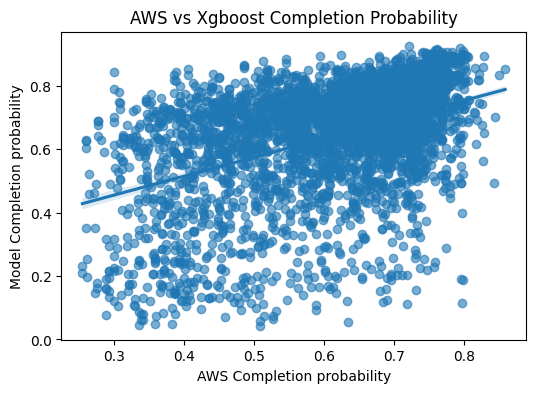

In [75]:
plt.figure(figsize=(6, 4))
sns.regplot(data=full_data, x='cp', y='complete_prob', scatter_kws={'alpha': 0.6})
plt.title("AWS vs Xgboost Completion Probability")
plt.xlabel("AWS Completion probability")
plt.ylabel("Model Completion probability")
plt.savefig('figures/completion_probability_comparison.png', dpi = 800)

x = full_data['cp']
y = full_data['complete_prob']
reg = linregress(x, y)
slope = reg.slope
intercept = reg.intercept
r_value = reg.rvalue
r2 = r_value**2
p_value = reg.pvalue
std_err = reg.stderr

print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r2)
print("p-value:", p_value)
print("Std error:", std_err)

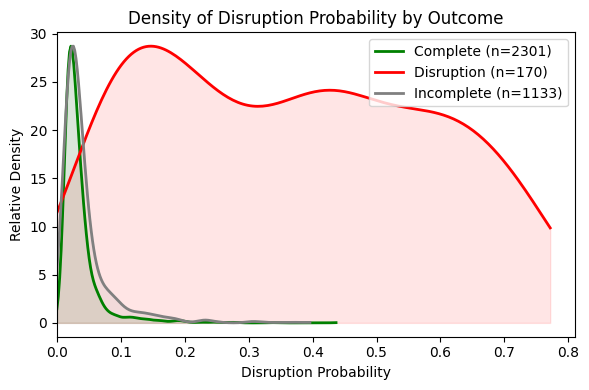

In [74]:
outcomes = ['Complete', 'Disruption', 'Incomplete']
plt.figure(figsize=(6, 4))
colors = {
    'Disruption': 'red',
    'Incomplete': 'grey',
    'Complete': 'green'
}

kde_y = {}
kde_x = {}
global_max = 0
for o in outcomes:
    subset = data[data['outcome'] == o]['disruption_prob']
    temp = sns.kdeplot(subset, clip=(0, subset.max()), bw_method='scott', color='black')
    line = temp.get_lines()[-1]
    x_vals = line.get_xdata()
    y_vals = line.get_ydata()
    kde_x[o] = x_vals
    kde_y[o] = y_vals
    global_max = max(global_max, y_vals.max())
    temp.remove()  # remove temporary curve
for o in outcomes:
    subset = data[data['outcome'] == o]['disruption_prob']
    x_vals = kde_x[o]
    y_vals = kde_y[o] 
    scale = global_max / y_vals.max() if y_vals.max() > 0 else 1
    y_scaled = y_vals * scale
    plt.fill_between(x_vals, y_scaled, alpha=0.1, color=colors[o])
    plt.plot(x_vals, y_scaled, linewidth=2, color=colors[o],
             label=f"{o} (n={len(subset)})")
plt.xlim(left=0)
plt.xlabel('Disruption Probability')
plt.ylabel("Relative Density")
plt.title('Density of Disruption Probability by Outcome')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig('figures/density_by_outcome.png', dpi = 800)

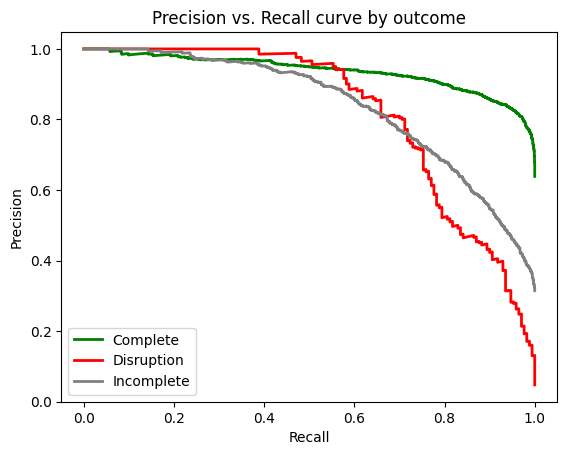

In [69]:
outcome_binarized = label_binarize(data.outcome, classes=['Complete', 'Disruption', 'Incomplete'])
precision = dict()
recall = dict()
for i in range(3):
    precision[i], recall[i], _ = metrics.precision_recall_curve(outcome_binarized[:, i], prediction_prob[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=outcomes[i], color=colors[outcomes[i]])
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve by outcome")
plt.show()

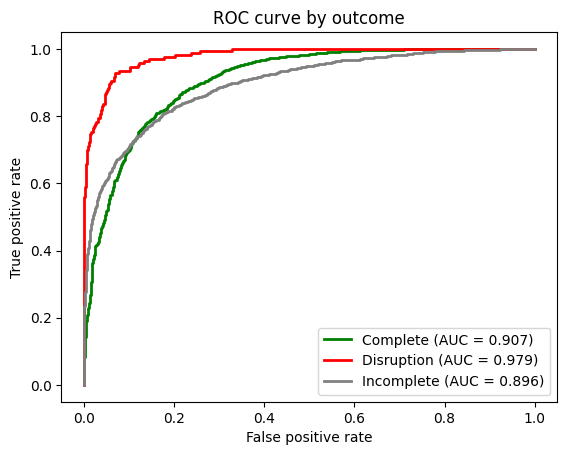

In [72]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = metrics.roc_curve(
        outcome_binarized[:, i],
        prediction_prob[:, i]
    )
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label=f"{outcomes[i]} (AUC = {roc_auc[i]:.3f})",
        color=colors[outcomes[i]]
    )

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve by outcome")
plt.legend(loc="best")
plt.savefig('figures/ROC_by_outcome.png', dpi = 800)

# Model Importance + SHAP

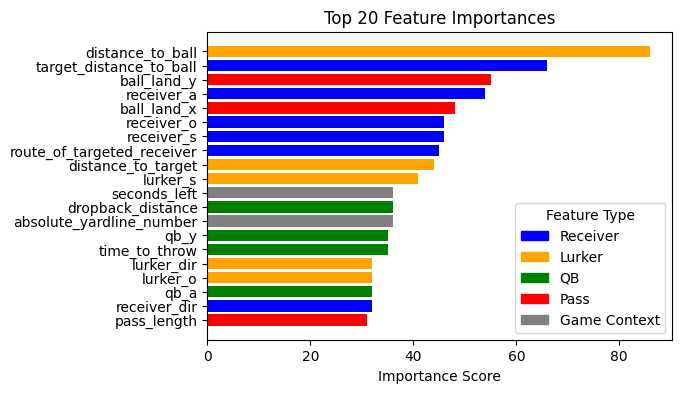

In [22]:
feature_important = loaded_model.get_score(importance_type='weight')
fi_keys = list(feature_important.keys())
fi_values = list(feature_important.values())
feature_importances = pd.DataFrame(data=fi_values, index=fi_keys, columns=["score"]).sort_values(by = "score", ascending=False)
feature_importances = feature_importances.head(20)

receiver_attributes = ['receiver_s', 'receiver_a', 'receiver_dir', 'receiver_o',
                      'target_distance_to_ball', 'route_of_targeted_receiver', 'receiver_x', 'receiver_y']
lurker_attributes = ['player_height', 'player_position', 'lurker_x',
                    'lurker_y', 'lurker_s', 'lurker_a', 'lurker_dir',
                    'lurker_o', 'distance_to_target', 'distance_to_ball', 'depth_difference']
qb_attributes = ['qb_x', 'qb_y', 'qb_s', 'qb_a', 'qb_dir', 'qb_o', 'time_to_throw', 'qb_hit',
                 'dropback_type', 'dropback_distance']
pass_attributes = ['pass_length', 'play_action', 'ball_land_x', 'ball_land_y']
game_context = ['absolute_yardline_number', 'down', 'yards_to_go', 'defensive_point_diff', 'seconds_left',
               'team_coverage_type', 'defenders_in_the_box']

colors = []
for feat in feature_importances.index:
    if feat in receiver_attributes:
        colors.append('blue')
    elif feat in lurker_attributes:
        colors.append('orange')
    elif feat in qb_attributes:
        colors.append('green')
    elif feat in pass_attributes:
        colors.append('red')
    elif feat in game_context:
        colors.append('grey')

# Plot horizontal bar chart
plt.figure(figsize=(6, 4))
plt.barh(feature_importances.index, feature_importances['score'], color=colors)
plt.gca().invert_yaxis()  # largest on top
plt.xlabel('Importance Score')
legend_patches = [mpatches.Patch(color='blue', label='Receiver'),
                  mpatches.Patch(color='orange', label='Lurker'),
                  mpatches.Patch(color='green', label='QB'),
                  mpatches.Patch(color='red', label='Pass'),
                  mpatches.Patch(color='grey', label='Game Context')]
plt.legend(handles=legend_patches, title = 'Feature Type');
plt.title('Top 20 Feature Importances');

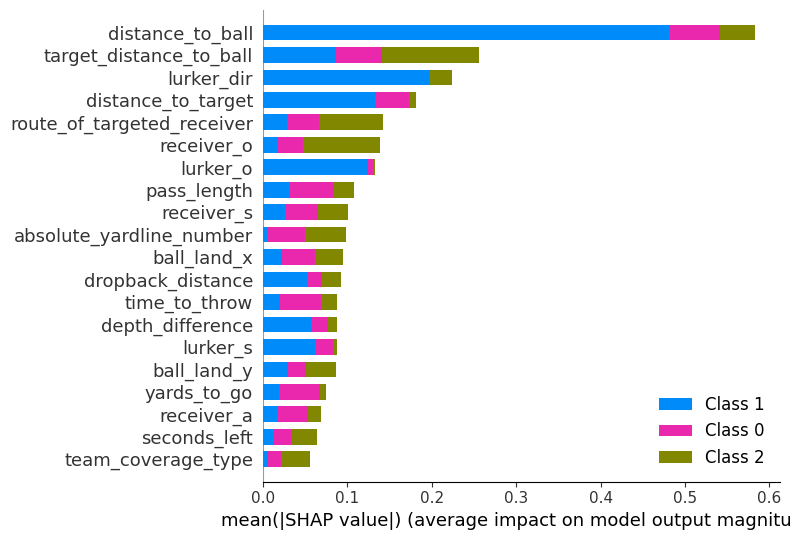

In [23]:
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(Xy_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", plot_size = 0.2)

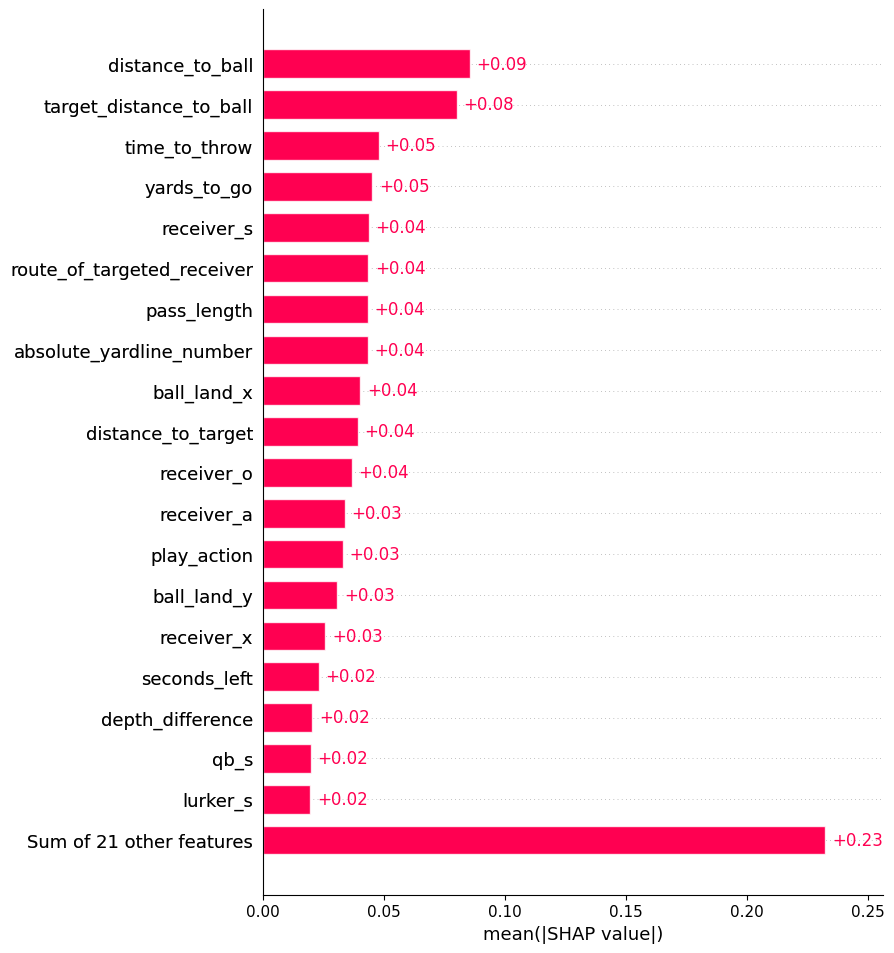

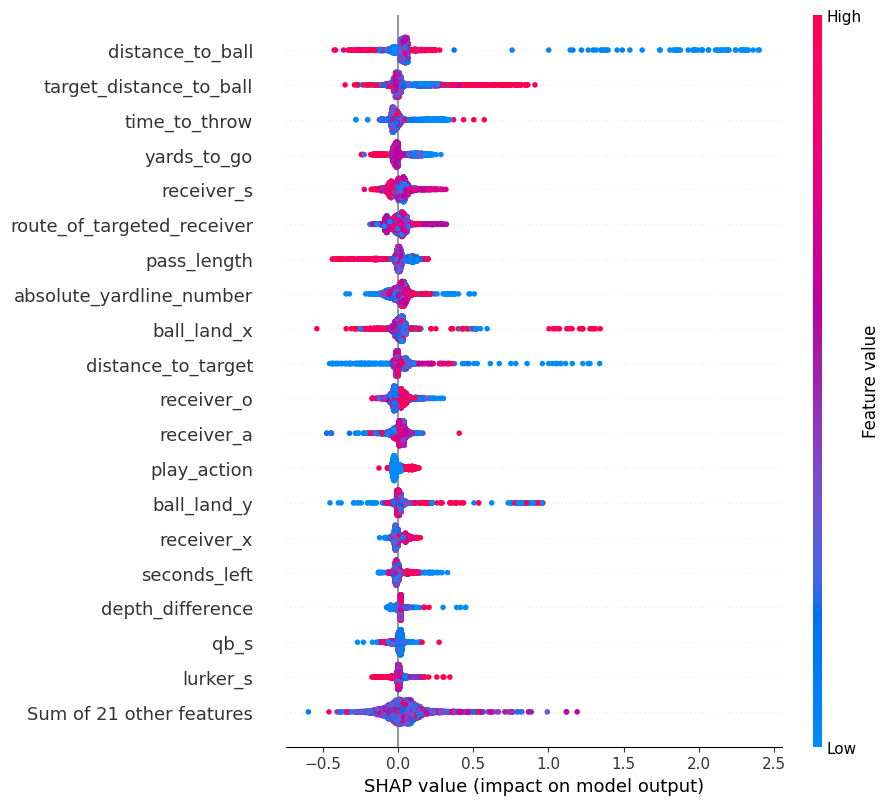

In [24]:
# Aggregated SHAP values
agg_shap_values = explainer(Xy_train)
new_shap_values = []
for i, pred in enumerate(predictions):
    new_shap_values.append(agg_shap_values.values[i][:, pred])
agg_shap_values.values = np.array(new_shap_values)
agg_shap_values.feature_names = X_train.columns
shap.plots.bar(agg_shap_values, max_display = 20) # average contribution of feature to predicted class
shap.plots.beeswarm(agg_shap_values, max_display = 20) #

# Player Results

In [25]:
player_results = full_data.groupby('player_name').agg(
    plays=('play_id', 'size'),
    disruptions=('outcome', lambda x: (x == 'Disruption').sum()),
    exp_disruptions=('disruption_prob', 'sum'),
    completions=('outcome', lambda x: (x == 'Complete').sum())).reset_index()
player_results['disruptions_oe'] = player_results['disruptions'] - player_results['exp_disruptions']
player_results['completion_percentage'] = player_results['completions']/player_results['plays']
player_results = player_results.drop(['completions'], axis = 1)
player_results = player_results.sort_values(by = 'plays', ascending = False)

In [26]:
most_lurk_opportunities = player_results[player_results.plays >= 25].reset_index(drop = True)
most_lurk_opportunities.round(2)

,player_name,plays,disruptions,exp_disruptions,disruptions_oe,completion_percentage
0,T.J. Edwards,43,3,2.53,0.47,0.56
1,Kenny Moore II,39,0,1.76,-1.76,0.54
2,Devin Lloyd,38,2,2.69,-0.69,0.68
3,"Kenneth Murray, Jr.",36,1,1.47,-0.47,0.75
4,Alex Singleton,32,0,0.94,-0.94,0.81
5,Patrick Queen,32,1,1.34,-0.34,0.78
6,Eric Kendricks,32,3,2.63,0.37,0.62
7,Lavonte David,31,1,1.78,-0.78,0.58
8,Dre Greenlaw,31,1,0.92,0.08,0.68
9,Foye Oluokun,31,2,1.29,0.71,0.61


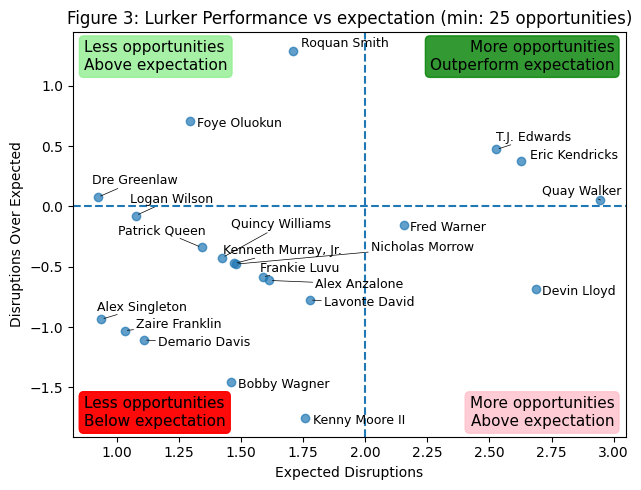

In [77]:
plt.figure(figsize=(6.5, 5))

plt.scatter(
    most_lurk_opportunities['exp_disruptions'],
    most_lurk_opportunities['disruptions_oe'],
    alpha=0.7
)

texts = []
for _, row in most_lurk_opportunities.iterrows():
    texts.append(
        plt.text(
            row['exp_disruptions'],
            row['disruptions_oe'],
            row['player_name'],
            fontsize=9
        )
    )

plt.axhline(0, linestyle='--')
plt.axvline(2, linestyle='--')
plt.xlabel('Expected Disruptions')
plt.ylabel('Disruptions Over Expected')
plt.title('Figure 3: Lurker Performance vs expectation (min: 25 opportunities)')

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', lw=0.5)
)

plt.annotate(
    "More opportunities\nOutperform expectation",
    xy=(0.98, 0.98),                
    xycoords='axes fraction',
    ha='right',
    va='top',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', alpha=0.8, facecolor='green', edgecolor='green')
)

plt.annotate(
    "Less opportunities\nAbove expectation",
    xy=(0.02, 0.98),               
    xycoords='axes fraction',
    ha='left',
    va='top',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', alpha=0.8, facecolor='lightgreen', edgecolor='lightgreen')
)
plt.annotate(
    "Less opportunities\nBelow expectation",
    xy=(0.02, 0.1),                
    xycoords='axes fraction',
    ha='left',
    va='top',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', alpha=0.8, facecolor='red', edgecolor='red')
)
plt.annotate(
    "Less opportunities\nBelow expectation",
    xy=(0.02, 0.1),               
    xycoords='axes fraction',
    ha='left',
    va='top',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', alpha=0.8, facecolor='red', edgecolor='red')
)

plt.annotate(
    "More opportunities\nAbove expectation",
    xy=(0.98, 0.1),              
    xycoords='axes fraction',
    ha='right',
    va='top',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', alpha=0.8, facecolor='pink', edgecolor='pink')
)
plt.tight_layout()
plt.savefig('figures/lurker_peformance_vs_expectation', dpi = 800)

In [19]:
disruptions_over_expected = player_results.sort_values(by = 'disruptions_oe', ascending = False).reset_index(drop=True)
disruptions_over_expected[disruptions_over_expected['disruptions_oe'] > 1]

,player_name,plays,disruptions,exp_disruptions,disruptions_oe,completion_percentage
0,Tyrique Stevenson,13,4,2.292625,1.707375,0.384615
1,Deion Jones,5,2,0.360400,1.639600,0.600000
2,Amani Hooker,4,2,0.372975,1.627025,0.250000
3,Darrell Baker Jr.,7,3,1.422699,1.577301,0.571429
4,Paulson Adebo,7,2,0.517733,1.482267,0.571429
5,Jerry Jacobs,6,2,0.598664,1.401336,0.333333
6,Jordan Fuller,9,2,0.647536,1.352464,0.222222
7,Isaac Yiadom,6,2,0.658283,1.341717,0.333333
8,Roquan Smith,30,3,1.708814,1.291186,0.600000
9,Blake Cashman,16,2,0.732859,1.267141,0.375000


In [20]:
most_expected_disruptions = player_results.sort_values(by = 'exp_disruptions', ascending = False).reset_index(drop=True)
most_expected_disruptions[most_expected_disruptions.exp_disruptions >= 1.5]

,player_name,plays,disruptions,exp_disruptions,disruptions_oe,completion_percentage
0,Quay Walker,27,3,2.946701,0.053299,0.666667
1,Devin Lloyd,38,2,2.686350,-0.686350,0.684211
2,Eric Kendricks,32,3,2.626940,0.373060,0.625000
3,T.J. Edwards,43,3,2.527900,0.472100,0.558140
4,Tyrique Stevenson,13,4,2.292625,1.707375,0.384615
5,Fred Warner,25,2,2.156193,-0.156193,0.680000
6,Lavonte David,31,1,1.776084,-0.776084,0.580645
7,Kenny Moore II,39,0,1.757242,-1.757242,0.538462
8,Roquan Smith,30,3,1.708814,1.291186,0.600000
9,Jordan Hicks,22,2,1.688509,0.311491,0.681818


# Identifying play examples for video

In [21]:
most_likely_disruptions = data[data['outcome'] == 'Complete'].sort_values('disruption_prob', ascending = False)
most_likely_disruption_plays = most_likely_disruptions[['game_id', 'play_id', 'disruption_prob', 'player_name']].merge(supplementary_data, how = 'inner', on = ['game_id', 'play_id'])
most_likely_disruption_plays = most_likely_disruption_plays[['game_id', 'play_id', 'week', 'home_team_abbr', 'visitor_team_abbr', 'quarter', 'play_description', 'disruption_prob', 'player_name']]
most_likely_disruption_plays['qb'] = [x.index('.') for x in most_likely_disruption_plays['play_description']]
most_likely_disruption_plays['qb'] = [y[x+1:x+20].split(' ')[0] for x, y in zip(most_likely_disruption_plays['qb'], most_likely_disruption_plays['play_description'])]
most_likely_disruption_plays[0:20]

,game_id,play_id,week,home_team_abbr,visitor_team_abbr,quarter,play_description,disruption_prob,player_name,qb
0,2023091012,2034,1,SEA,LA,2,(:16) (Shotgun) M.Stafford pass short middle t...,0.436631,Bobby Wagner,Stafford
1,2023091011,2449,1,NE,PHI,3,(13:43) (Shotgun) J.Hurts pass short middle to...,0.336274,Jahlani Tavai,Hurts
2,2023091010,630,1,LAC,MIA,1,(4:33) (Shotgun) T.Tagovailoa pass short middl...,0.281475,"Kenneth Murray, Jr.",Tagovailoa
3,2023112601,1030,12,CIN,PIT,2,(11:50) J.Browning pass short middle to J.Chas...,0.275552,Trenton Thompson,Browning
4,2023110505,294,9,HOU,TB,1,(12:56) C.Stroud pass short right to D.Schultz...,0.266259,Carlton Davis III,Stroud
5,2023112302,2279,12,SEA,SF,3,"(13:21) (No Huddle, Shotgun) G.Smith pass shor...",0.259317,Javon Hargrave,Smith
6,2023120308,750,13,LA,CLE,1,(3:59) J.Flacco pass deep middle to H.Bryant t...,0.245023,Troy Reeder,Flacco
7,2023092406,4004,3,MIN,LAC,4,(8:51) (Shotgun) J.Herbert pass deep middle to...,0.244336,Jordan Hicks,Herbert
8,2023101501,4005,6,ATL,WAS,4,"(1:40) (No Huddle, Shotgun) D.Ridder pass shor...",0.243691,Danny Johnson,Ridder
9,2023092501,336,3,CIN,LA,1,(10:15) (Shotgun) M.Stafford pass short middle...,0.228970,Germaine Pratt,Stafford


In [54]:
#wagner, 2023091012, 2034, distance to ball only 4.7 yards
#pratt, 2023092501, 336, distance to ball only 3.4 yards
#melifonwu, 2023092402, 2819
#sutton, 2023111208, 3088
shap_exp = shap.Explanation( values=shap_values, base_values=explainer.expected_value, data=X_train.values, feature_names=X_train.columns )

# Slice class 1 first
shap_exp_class1 = shap.Explanation(
    values=shap_exp.values[:, :, 1],        # values for class 1
    base_values=shap_exp.base_values[1],   # base value for class 1
    data=shap_exp.data,                     # same data
    feature_names=shap_exp.feature_names
) 

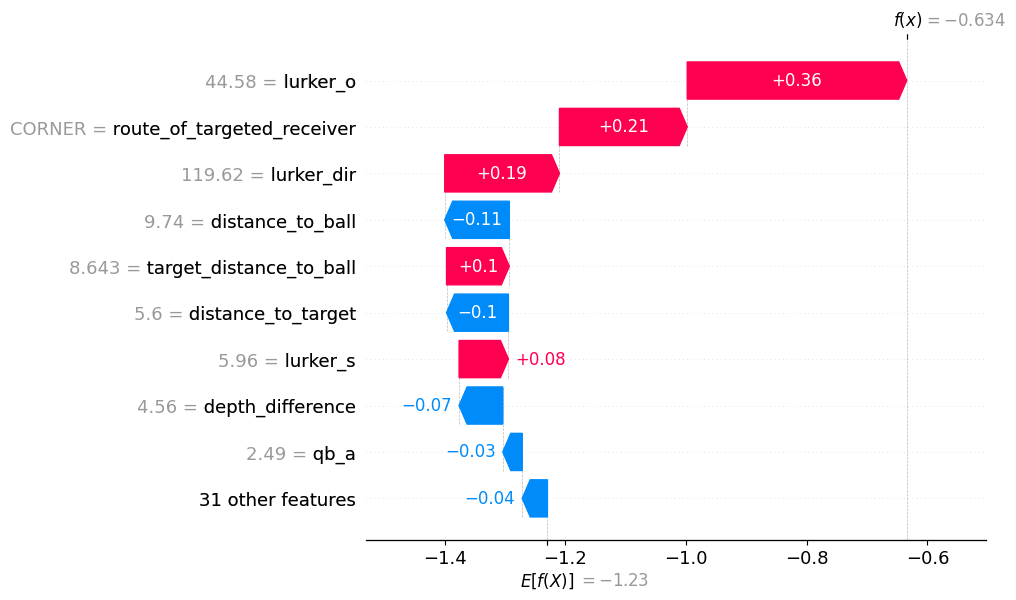

In [56]:
shap.plots.waterfall(shap_exp_class1[2015]) # Cameron Sutton

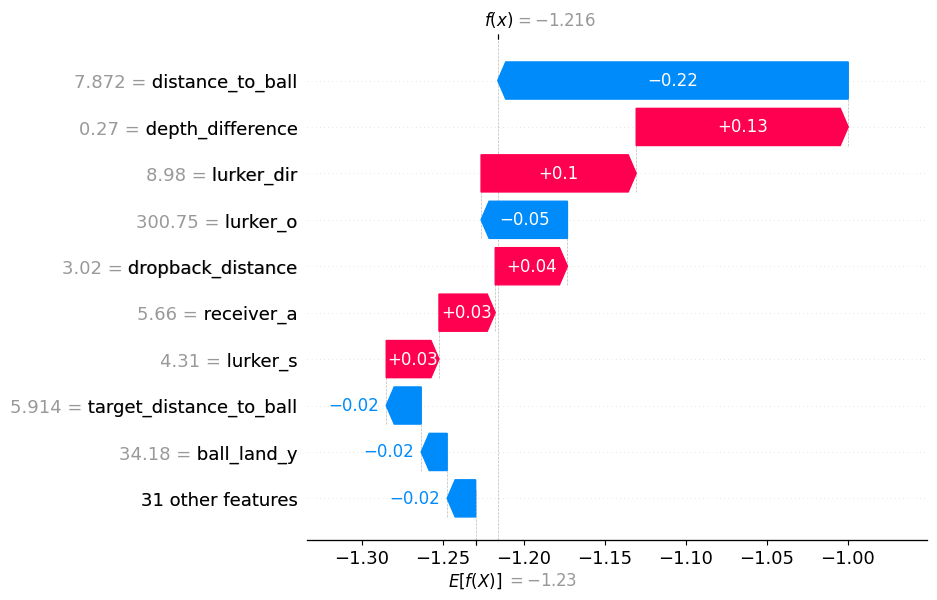

In [55]:
shap.plots.waterfall(shap_exp_class1[535]) # Melifonwu, 7.8 yards

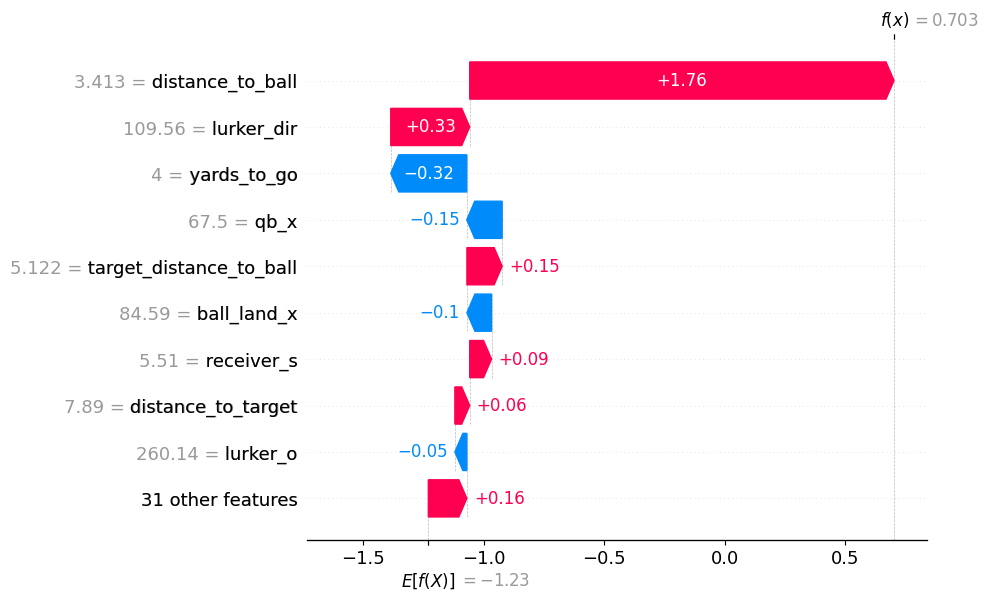

In [57]:
shap.plots.waterfall(shap_exp_class1[694]) # Pratt

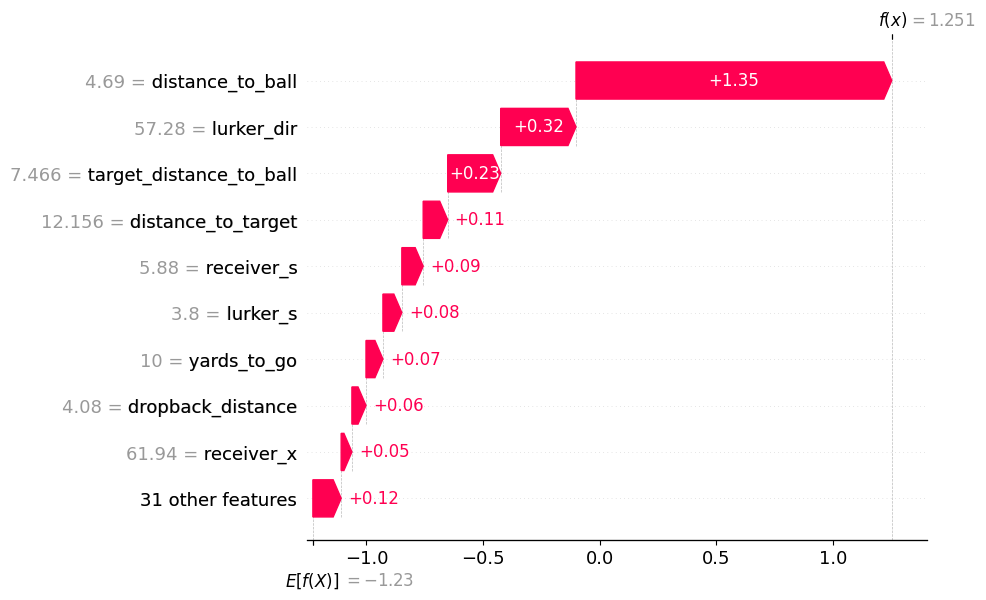

In [58]:
shap.plots.waterfall(shap_exp_class1[211]) # Wagner

Stafford week 1 vs Seahawks [found this play] 44/%
Stafford week 3 vs Bengals 23/%
Melifonwu 6\% on Ridder, 55
Cam Sutton Herbert 9.8, 68 

In [59]:
least_likely_disruptions = data[data['outcome'] == 'Disruption'].sort_values('disruption_prob')
least_likely_disruption_plays = least_likely_disruptions[['game_id', 'play_id', 'disruption_prob', 'player_name', 'cp']].merge(supplementary_data, how = 'inner', on = ['game_id', 'play_id'])
least_likely_disruption_plays = least_likely_disruption_plays[['game_id', 'play_id', 'week', 'home_team_abbr', 'visitor_team_abbr', 'quarter', 'play_description', 'disruption_prob', 'player_name', 'cp']]
pd.set_option('display.max_rows', 50)
least_likely_disruption_plays[least_likely_disruption_plays['disruption_prob'] < 0.2].sort_values('week')

,game_id,play_id,week,home_team_abbr,visitor_team_abbr,quarter,play_description,disruption_prob,player_name,cp
2,2023091010,1558,1,LAC,MIA,2,(8:20) (Shotgun) T.Tagovailoa pass incomplete ...,0.042364,Eric Kendricks,0.552396
5,2023091008,2749,1,CHI,GB,3,(3:38) (Shotgun) J.Love pass incomplete short ...,0.054894,Eddie Jackson,0.537768
24,2023091005,2964,1,NO,TEN,3,(4:50) (Shotgun) D.Carr pass incomplete short ...,0.106592,Amani Hooker,0.659844
31,2023091010,1513,1,LAC,MIA,2,(9:07) (Shotgun) T.Tagovailoa pass incomplete ...,0.120714,Michael Davis,0.385268
47,2023091005,2283,1,NO,TEN,2,"(:37) (No Huddle, Shotgun) D.Carr pass deep mi...",0.185394,Amani Hooker,0.598744
14,2023091708,2043,2,ARI,NYG,2,(:23) (Shotgun) D.Jones pass incomplete short ...,0.087770,Krys Barnes,0.744156
36,2023091400,685,2,PHI,MIN,1,(3:04) (Shotgun) J.Hurts pass deep middle inte...,0.133208,Theo Jackson,0.519777
25,2023091710,1322,2,DAL,NYJ,2,(7:45) D.Prescott pass incomplete short middle...,0.106736,C.J. Mosley,0.560516
43,2023091800,1945,2,CAR,NO,2,(3:16) (Shotgun) D.Carr pass deep right intend...,0.175313,Vonn Bell,0.414846
30,2023092406,4823,3,MIN,LAC,4,(:12) (Shotgun) K.Cousins pass short right int...,0.116649,"Kenneth Murray, Jr.",0.454237


# Predict and Graph a Play

In [427]:
#Alex Highsmith deflection vs browning

In [60]:
frame_data = pd.read_csv('Data/input_2023_w16.csv')
frame_data['x'] = 120 - frame_data['x']
frame_data['y'] = 53.3 - frame_data['y']
frame_data['ball_land_x'] = 120 - frame_data['ball_land_x']
frame_data['ball_land_y'] = 53.3 - frame_data['ball_land_y']
frame_data['o'] = (180 + frame_data['o']) % 360
frame_data['dir'] = (180 + frame_data['dir']) % 360

In [61]:
highsmith_data = frame_data[(frame_data['game_id'] == 2023122300) & (frame_data['play_id'] == 3443) & (frame_data['player_name'] == 'Alex Highsmith')]
receiver_data = frame_data[(frame_data['game_id'] == 2023122300) & (frame_data['play_id'] == 3443) & (frame_data['player_role'] == 'Targeted Receiver')]
qb_data = frame_data[(frame_data['game_id'] == 2023122300) & (frame_data['play_id'] == 3443) & (frame_data['player_role'] == 'Passer')]
highsmith_data = highsmith_data.merge(receiver_data.rename(columns={'x': 'target_x', 'y': 'target_y'})[['game_id', 'play_id', 'frame_id', 'target_x', 'target_y']], 
                              on=['game_id', 'play_id', 'frame_id'], how='inner')
receiver_data['target_distance_to_ball'] = np.sqrt(
    (receiver_data['ball_land_x'] - receiver_data['x'])**2 + (receiver_data['ball_land_y'] - receiver_data['y'])**2
)
receiver_data = receiver_data.rename(columns={c: f"receiver_{c}" for c in ['x', 'y', 's', 'a', 'dir', 'o']})
qb_data = qb_data.rename(columns={c: f"qb_{c}" for c in ['x', 'y', 's', 'a', 'dir', 'o']})
# distance to target
highsmith_data['distance_to_target'] = np.sqrt(
    (highsmith_data['target_x'] - highsmith_data['x'])**2 + (highsmith_data['target_y'] - highsmith_data['y'])**2
)
# distance to ball
highsmith_data['distance_to_ball'] = np.sqrt(
    (highsmith_data['ball_land_x'] - highsmith_data['x'])**2 + (highsmith_data['ball_land_y'] - highsmith_data['y'])**2
)
# depth difference
highsmith_data['depth_difference'] = highsmith_data['target_x'] - highsmith_data['x']
highsmith_data = highsmith_data.rename(columns={c: f"lurker_{c}" for c in ['x', 'y', 's', 'a', 'dir', 'o']})

highsmith_data = highsmith_data.merge(receiver_data[['game_id', 'play_id', 'frame_id', 'receiver_x', 'receiver_y',
                                      'receiver_s', 'receiver_a', 'receiver_dir', 'receiver_o', 'target_distance_to_ball']], 
                                      on = ['game_id', 'play_id', 'frame_id'], how = 'inner')
highsmith_data = highsmith_data.merge(qb_data[['game_id', 'play_id', 'frame_id', 'qb_x', 'qb_y',
                                      'qb_s', 'qb_a', 'qb_dir', 'qb_o']], on = ['game_id', 'play_id', 'frame_id'], how = 'inner')

In [62]:
highsmith_training_data = highsmith_data[['absolute_yardline_number', 'lurker_x', 'lurker_y', 'lurker_s', 
       'lurker_a', 'lurker_dir', 'lurker_o', 'ball_land_x', 'ball_land_y',
       'distance_to_target', 'distance_to_ball', 'depth_difference',
       'receiver_x', 'receiver_y', 'receiver_s', 'receiver_a', 'receiver_dir',
       'receiver_o', 'target_distance_to_ball', 'qb_x', 'qb_y', 'qb_s', 'qb_a',
       'qb_dir', 'qb_o']]

extra_cols = ['player_height', 'player_position', 'time_to_throw', 'down', 'yards_to_go', 
              'defensive_point_diff', 'pass_length', 'play_action', 'dropback_type', 
              'dropback_distance', 'team_coverage_type', 'defenders_in_the_box', 
              'route_of_targeted_receiver', 'qb_hit', 'seconds_left']
row_values = X_train.loc[3066, extra_cols]
for col in extra_cols:
    highsmith_training_data[col] = row_values[col]
highsmith_training_data['player_position'] = highsmith_training_data['player_position'].astype('category')
highsmith_training_data['play_action'] = highsmith_training_data['play_action'].astype('category')
highsmith_training_data['dropback_type'] = highsmith_training_data['dropback_type'].astype('category')
highsmith_training_data['team_coverage_type'] = highsmith_training_data['team_coverage_type'].astype('category')
highsmith_training_data['route_of_targeted_receiver'] = highsmith_training_data['route_of_targeted_receiver'].astype('category')
highsmith_training_data['qb_hit'] = highsmith_training_data['qb_hit'].astype('category')
highsmith_training_data['down'] = highsmith_training_data['down'].astype('category')

feature_order = [
    'absolute_yardline_number', 'player_height', 'player_position', 'lurker_x', 'lurker_y', 'lurker_s', 'lurker_a', 'lurker_dir', 'lurker_o', 'ball_land_x', 'ball_land_y', 'distance_to_target', 'distance_to_ball', 'depth_difference', 'time_to_throw', 'receiver_x', 'receiver_y', 'receiver_s', 'receiver_a', 'receiver_dir', 'receiver_o', 'target_distance_to_ball', 'qb_x', 'qb_y', 'qb_s', 'qb_a', 'qb_dir', 'qb_o', 'down', 'yards_to_go', 'defensive_point_diff', 'pass_length', 'play_action', 'dropback_type', 'dropback_distance', 'team_coverage_type', 'defenders_in_the_box', 'route_of_targeted_receiver', 'qb_hit', 'seconds_left'
]

highsmith_training_data = highsmith_training_data[feature_order]
highsmith_X = xgb.DMatrix(highsmith_training_data, enable_categorical = True)
highsmith_predictions = loaded_model.predict(highsmith_X)

In [63]:
highsmith_predictions

array([[0.46821266, 0.02309306, 0.5086943 ],
       [0.48382035, 0.02386286, 0.4923168 ],
       [0.5122751 , 0.0218096 , 0.4659153 ],
       [0.52639395, 0.02416691, 0.44943914],
       [0.5262741 , 0.02473708, 0.4489888 ],
       [0.5508455 , 0.02589204, 0.42326245],
       [0.5508455 , 0.02589204, 0.42326245],
       [0.5446897 , 0.0262469 , 0.42906335],
       [0.5413935 , 0.02643691, 0.43216956],
       [0.51642686, 0.02585982, 0.4577133 ],
       [0.54203767, 0.02485801, 0.43310434],
       [0.54203767, 0.02485801, 0.43310434],
       [0.5453338 , 0.03012912, 0.4245371 ],
       [0.50487643, 0.03516769, 0.45995584],
       [0.5036129 , 0.03758246, 0.4588047 ],
       [0.5036129 , 0.03758246, 0.4588047 ],
       [0.44680843, 0.03875271, 0.51443887],
       [0.41512278, 0.03722885, 0.5476484 ],
       [0.391189  , 0.05116623, 0.5576447 ],
       [0.4229198 , 0.05272027, 0.52435994],
       [0.4229198 , 0.05272027, 0.52435994],
       [0.53962004, 0.04358932, 0.41679063],
       [0.